In [92]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import calendar
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from numpy import array
from math import sqrt
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import keras.backend as K
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from random import random
#!pip install pmdarima --quiet
import pmdarima as pm

# Code adapted from https://medium.com/data-science/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6
# Plot data to view
def plot_data(df, feature):
    plt.figure(figsize=(15,7))
    plt.title(str(feature)+" by Month")
    plt.xlabel('Month')
    plt.ylabel(str(feature))
    plt.plot(df)
    plt.show()

#Determine rolling statistics to find trends
def rolling_statistics(df):
    df["rolling_avg"] = df[df.columns[0]].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
    df["rolling_std"] = df[df.columns[0]].rolling(window=12).std()

    #Plot rolling statistics
    plt.figure(figsize=(15,7))
    plt.plot(df, color='#379BDB', label='Original')
    plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
    plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

#Augmented Dickey-Fuller Test to test if the time series is stationary
#If ADF has p <= 0.05, data are stationary
def ADF(df):
    print('Results of Dickey Fuller Test for temperature:')
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)

    return dfoutput

def add_padding(y):

    # Create rows of padding with zeros
    if isinstance(y[0][0], float) or isinstance(y[0][0], int):
        n_vars = 1
    else:
        n_vars = len(y[0][0])

    if n_vars == 1:
        padding = 0 * n_vars
    else:
        padding = [0 * n_vars]

    data = []
    
    for p in range(len(y)):
        for q in range(len(y[0])):
            data.append(y[p][q])
        
        for r in range(12):
            data.append(padding)

    return data

#Standard ARIMA Model
def fit_ARIMA_model(y, y_val, n_seq):

    best_p = 1
    best_q = 1
    best_rmse = -1

    for p in range(13):
        for q in range(13):
            # Check rmse for each fold
            for k in range(5):
                cv_errors = []
                cv_mae = []
                cv_mape = []
                cv_r2 = []
                series = pd.Series(y[k])
                
                model = pm.auto_arima(add_padding(y[k]), start_p=p, start_q=q, test='adf', # use adftest to find optimal 'd' 
                          max_p=p, max_q=q, # maximum p and q
                          m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                          d=None,# let model determine 'd'
                          seasonal=False, # No Seasonality for standard ARIMA
                          trace=False, #logs 
                          error_action='warn', #shows errors ('ignore' silences these)
                          suppress_warnings=True,
                          stepwise=True
                         )
                
                model_fit = model.fit(y_val)
                print(model_fit.summary())

                # Taken from https://medium.com/pythons-gurus/multi-step-forecasting-with-arima-predicting-long-term-climate-trends-291e5e08c2a2
                # Number of steps to forecast
                forecast_steps = n_seq

                # Perform multi-step forecasting
                forecast = model_fit.get_forecast(steps=forecast_steps)
                forecast_values = forecast.predicted_mean
                confidence_intervals = forecast.conf_int()

                print("forecast:")
                print(forecast)
                print(forecast_values)
                print(confidence_intervals)
                
                # Plot the results
                plt.figure(figsize=(14, 7))
                plt.plot(data.index, data['Temperature'], label='Observed Temperature')
                forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='M')[1:]
                plt.plot(forecast_index, forecast_values, label='Forecasted Temperature', linestyle='--')
                plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
                plt.title('Multi-step Temperature Forecast')
                plt.xlabel('Month')
                plt.ylabel('Temperature')
                plt.legend()
                plt.show()

                #Make predictions
                predictions = model_fit.predict(start=len(y[k]), end=len(series)-1)

                #Calculate the Root Mean Square Error (RMSE)
                mse = mean_squared_error(y_val[k], predictions)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_val[k], predictions)
                mape = mean_absolute_percentage_error(y_val[k], predictions)
                r2 = r2_score(y_val[k], predictions)
                cv_errors.append(rmse)
                cv_mae.append(mae)
                cv_mape.append(mape)
                cv_r2.append(r2)

            print("RMSE values for ARIMA model p="+str(p)+", q="+str(q)+":")
            print(cv_errors)
            
            # Print evaluation results
            print("Average of RMSE fold values: "+str(np.mean(cv_errors)))
            print("Standard Deviation of RMSE fold values: "+str(np.stdev(cv_errors)))
            print(f"Mean Absolute Error: {np.mean(cv_mae)}")
            print(f"Mean Absolute Percentage Error: {np.mean(cv_mape)}")
            print(f"R2 Score: {np.mean(cv_r2)}")
            if best_rmse == -1 or np.mean(cv_errors) < best_rmse:
                best_rmse = np.mean(cv_errors)
            if np.mean(cv_errors) < best_rmse:
                best_p = p
                best_q = q

    print("Best model is p="+str(best_p)+", q="+str(best_q))
    print("with RMSE="+str(best_rmse))
    
    return model

# SARIMAX Model
def fit_SARIMAX_model(X, y, X_val, y_val, exog, n_seq):

    best_p = 1
    best_q = 1
    best_rmse = -1

    for p in range(13):
        for q in range(13):
            # Check rmse for each fold
            for k in range(5):
                cv_errors = []
                cv_mae = []
                cv_mape = []
                cv_r2 = []
                series = pd.Series(y[k])
    
                model = pm.auto_arima(add_padding(y[k]), start_p=p, start_q=q, exogenous=exog,
                         test='adf', # use adftest to find optimal 'd'
                         max_p=12, max_q=12, m=12, #12 is the frequency of the cycle
                         start_P=0, seasonal=True,
                         d=None, D=1, 
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

                model_fit = model.fit(X_val[k], y_val[k])
                print(model_fit.summary())

                # Taken from https://medium.com/pythons-gurus/multi-step-forecasting-with-arima-predicting-long-term-climate-trends-291e5e08c2a2
                # Number of steps to forecast
                forecast_steps = n_seq

                # Perform multi-step forecasting
                forecast = model_fit.get_forecast(steps=forecast_steps)
                forecast_values = forecast.predicted_mean
                confidence_intervals = forecast.conf_int()

                # Plot the results
                plt.figure(figsize=(14, 7))
                plt.plot(data.index, data['Temperature'], label='Observed Temperature')
                forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='M')[1:]
                plt.plot(forecast_index, forecast_values, label='Forecasted Temperature', linestyle='--')
                plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
                plt.title('Multi-step Temperature Forecast')
                plt.xlabel('Month')
                plt.ylabel('Temperature')
                plt.legend()
                plt.show()

                #Make predictions
                predictions = model_fit.predict(start=len(y[k]), end=len(series)-1)

                #Calculate the Root Mean Square Error (RMSE)
                mse = mean_squared_error(y_val[k], predictions)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_val[k], predictions)
                mape = mean_absolute_percentage_error(y_val[k], predictions)
                r2 = r2_score(y_val[k], predictions)
                cv_errors.append(rmse)
                cv_mae.append(mae)
                cv_mape.append(mape)
                cv_r2.append(r2)

            print("RMSE values for SARIMAX model p="+str(p)+", q="+str(q)+":")
            print(cv_errors)
            
            # Print evaluation results
            print("Average of RMSE fold values: "+str(np.mean(cv_errors)))
            print("Standard Deviation of RMSE fold values: "+str(np.stdev(cv_errors)))
            print(f"Mean Absolute Error: {np.mean(cv_mae)}")
            print(f"Mean Absolute Percentage Error: {np.mean(cv_mape)}")
            print(f"R2 Score: {np.mean(cv_r2)}")
            if best_rmse == -1 or np.mean(cv_errors) < best_rmse:
                best_rmse = np.mean(cv_errors)
            if np.mean(cv_errors) < best_rmse:
                best_p = p
                best_q = q

    print("Best model is p="+str(best_p)+", q="+str(best_q))
    print("with RMSE="+str(best_rmse))
    
    return model

def plot_diagnostics(model):
    model.plot_diagnostics(figsize=(15,12))
    plt.show
    
def ARIMA_forecast(ARIMA_model, df, periods=12):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df, color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA Forecast")
    plt.show()

    return fitted_series, lower_series, upper_series

def SARIMAX_forecast(SARIMAX_model, df, exog, periods=12):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=exog)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df, color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX Forecast")
    plt.show()

    return fitted_series, lower_series, upper_series

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))

# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# transform series into training sets
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        train.append([scaled_values_batch])
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([scaled_values_batch])
        else:
            validation.append([scaled_values_batch])
    
    return validation, test

def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))

def transform_data(data, n_lag, n_seq):
    
    X_row = []
    y_row = []
    temp_row = []
    sh_row = []
    PC1_row = []
    PC2_row = []
    PC3_row = []
    for j in range(len(data)):
        X2 = data[j]
        y2 = pd.DataFrame(X2[n_seq:n_lag+n_seq])
        X_row.append(pd.DataFrame(X2[:n_lag]))
        temp_row.append(X_row[j][X_row[j].columns[0]])
        sh_row.append(X_row[j][X_row[j].columns[1]])
        PC1_row.append(X_row[j][X_row[j].columns[2]])
        PC2_row.append(X_row[j][X_row[j].columns[3]])
        PC3_row.append(X_row[j][X_row[j].columns[4]])
        y_row.append(y2[y2.columns[0]])

    return X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row

#Main

#Configure
n_seq = 1
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])

#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])

train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10

#X1 = slp	
#X2 = wbt	
#X3 = water	
#X4 = GHI
#X5 = WDSP
#X6 = PRCP	
#X7 = SNDP	
#X8 = Region	
#X9 = SA	
#X10 = ONI

# Get the current working directory 
current_directory = os.getcwd() 

# Print the current working directory 
print(current_directory)

# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)

filename = path + 'Final_Monthly_Dataset.csv'

# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)

# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'Month', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

results_df = df_trimmed

# Calculate principal components excluding response variables
results_df['PC1']=-0.0004514*results_df['slp']+0.03194*results_df['wet_bulb_temperature']-0.04343*results_df['water']+0.002243*results_df['GHI']-0.02252*results_df['WDSP']
+0.9877*results_df['PRCP']-0.2265*results_df['SNDP']+0.006144*results_df['region']-0.0001488*results_df['solar_activity']+0.02943*results_df['ONI']
results_df['PC2']=0.0001702*results_df['slp']+0.005484*results_df['wet_bulb_temperature']+0.2057*results_df['water']-0.0003188*results_df['GHI']-0.02584*results_df['WDSP']
+1.6963*results_df['PRCP']-0.05890*results_df['SNDP']+0.05809*results_df['region']+1.9748*results_df['solar_activity']+0.03686*results_df['ONI']
results_df['PC3']=-0.00006323*results_df['slp']-0.001180*results_df['wet_bulb_temperature']-0.02384*results_df['water']-0.00002833*results_df['GHI']+0.01170*results_df['WDSP']
+0.5204*results_df['PRCP']+0.4791*results_df['SNDP']-0.004318*results_df['region']+0.008271*results_df['solar_activity']+0.8765*results_df['ONI']

# Drop columns that compose principal components
results_df = results_df.drop(['slp', 'wet_bulb_temperature', 'water', 'GHI', 'WDSP', 'PRCP', 'SNDP', 'region', 'solar_activity', 'ONI'], axis=1)

print(results_df)

print(results_df.columns)

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = results_df[results_df['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 

#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_scaling = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
    dataset_scaling = list(itertools.chain(*dataset)) # Holds all 84 weather station rows to train the scaling function

    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(vl_X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)    
    dataset_testing = list(itertools.chain(*dataset_test)) # Holds remaining 21 weather station rows for testing and validation

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    #dim_size = n_seq + 12*n_lag
    #train1 = np.array(train[i]).reshape(84, dim_size)
    #test1 = np.array(test[i]).reshape(11, dim_size)
    #validation1 = np.array(validation[i]).reshape(10, dim_size)
    #train2 = pd.DataFrame(train1).values
    #test2 = pd.DataFrame(test1).values
    #validation2 = pd.DataFrame(validation1).values
    #print(np.array(train2).shape)
    #print(np.array(test2).shape)
    #print(np.array(validation2).shape)

    #print(train2)

    #train[i] = train2
    #test[i] = test2
    #validation[i] = validation2
    
print("Finished")

Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
       file_id  temperatures  specific_humidity       PC1       PC2       PC3
0         6501         12.21               5.39 -0.155299  0.223029 -0.026192
1         6501          8.17               4.30 -0.193200  0.237213 -0.040096
2         6501         15.68               6.51  0.093451  0.213680 -0.030931
3         6501         22.46              10.21  0.456252  0.250143 -0.049469
4         6501         23.66              11.74  0.566777  0.269498 -0.059257
...        ...           ...                ...       ...       ...       ...
24057     9858         28.60              15.21       NaN       NaN       NaN
24058     9858         29.11              15.15       NaN       NaN       NaN
24059     9858         24.57              10.72       NaN       NaN       NaN
24060     9858         21.16               6.99       NaN       NaN

Fold 1:
(225, 1)


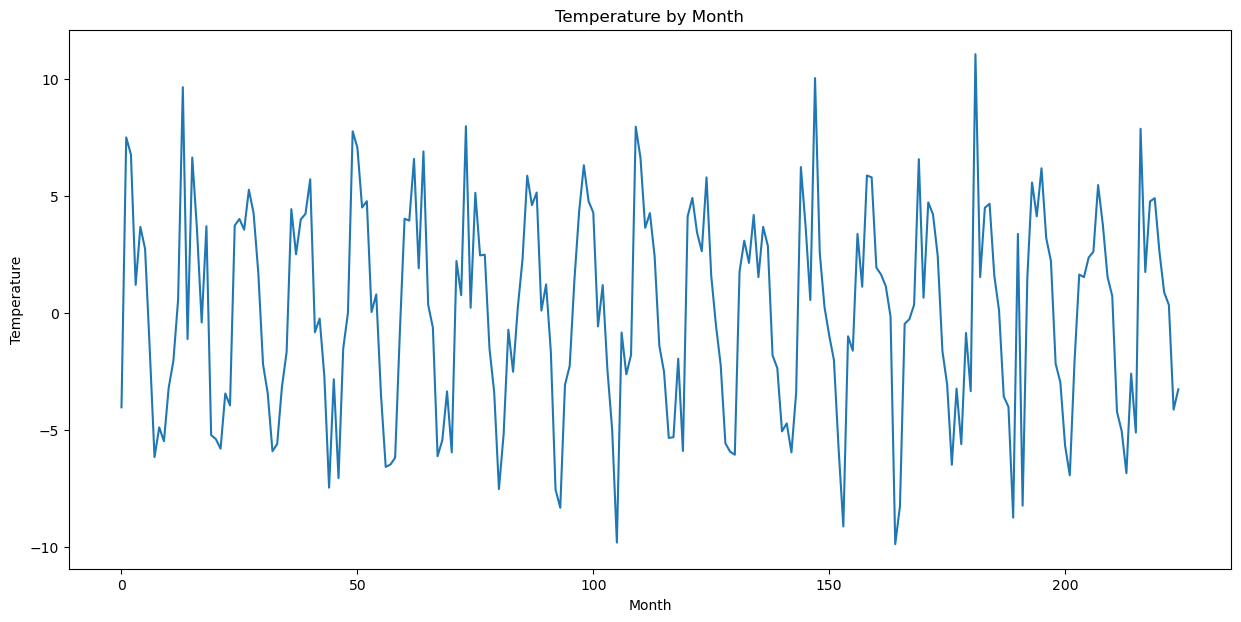

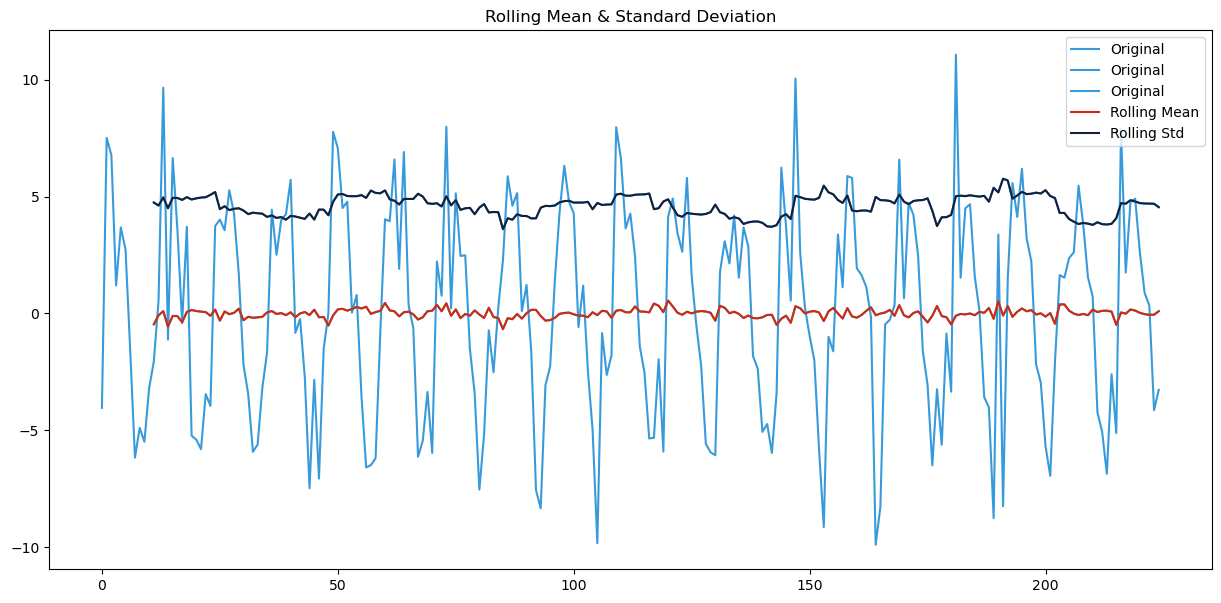

        0  rolling_avg  rolling_std
0   -4.04          NaN          NaN
1    7.51          NaN          NaN
2    6.78          NaN          NaN
3    1.20          NaN          NaN
4    3.68          NaN          NaN
..    ...          ...          ...
220  2.61     0.025833     4.721734
221  0.88    -0.029167     4.706312
222  0.34    -0.060833     4.702089
223 -4.14    -0.053333     4.694901
224 -3.27     0.095833     4.547490

[225 rows x 3 columns]
Results of Dickey Fuller Test for temperature:
Test Statistic                -1.353116e+01
p-value                        2.620039e-25
#Lags Used                     1.000000e+01
Number of Observations Used    2.140000e+02
Critical Value (1%)           -3.461282e+00
Critical Value (5%)           -2.875143e+00
Critical Value (10%)          -2.574020e+00
dtype: float64
Results of Dickey Fuller Test for temperature:
Test Statistic                  -2.284538
p-value                          0.177003
#Lags Used                      11.000000
N

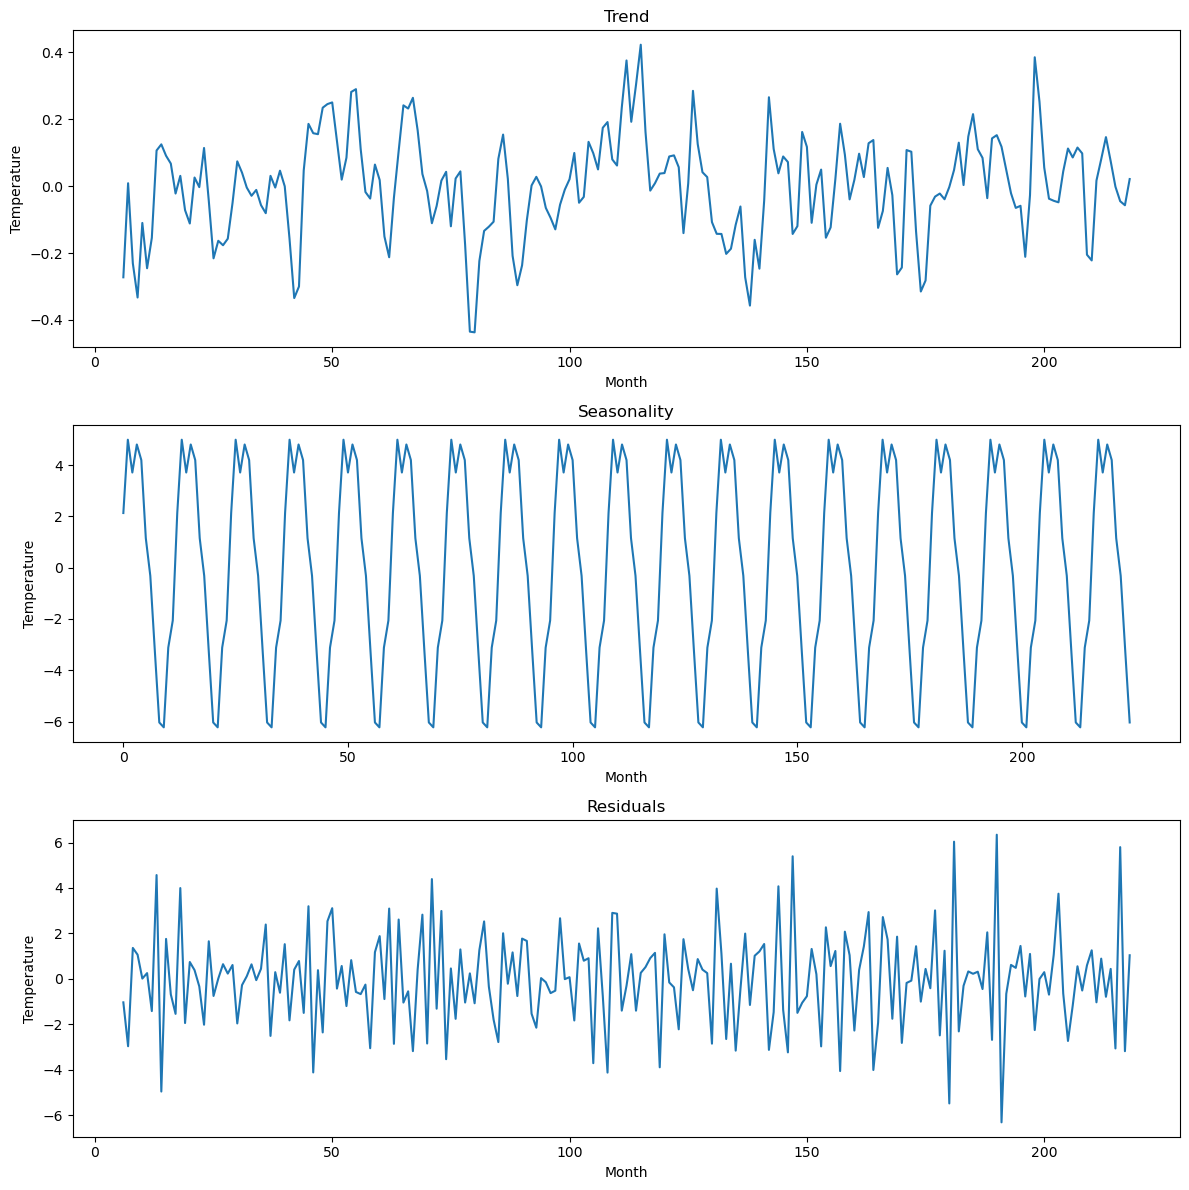

1
Fold 2:
(225, 1)


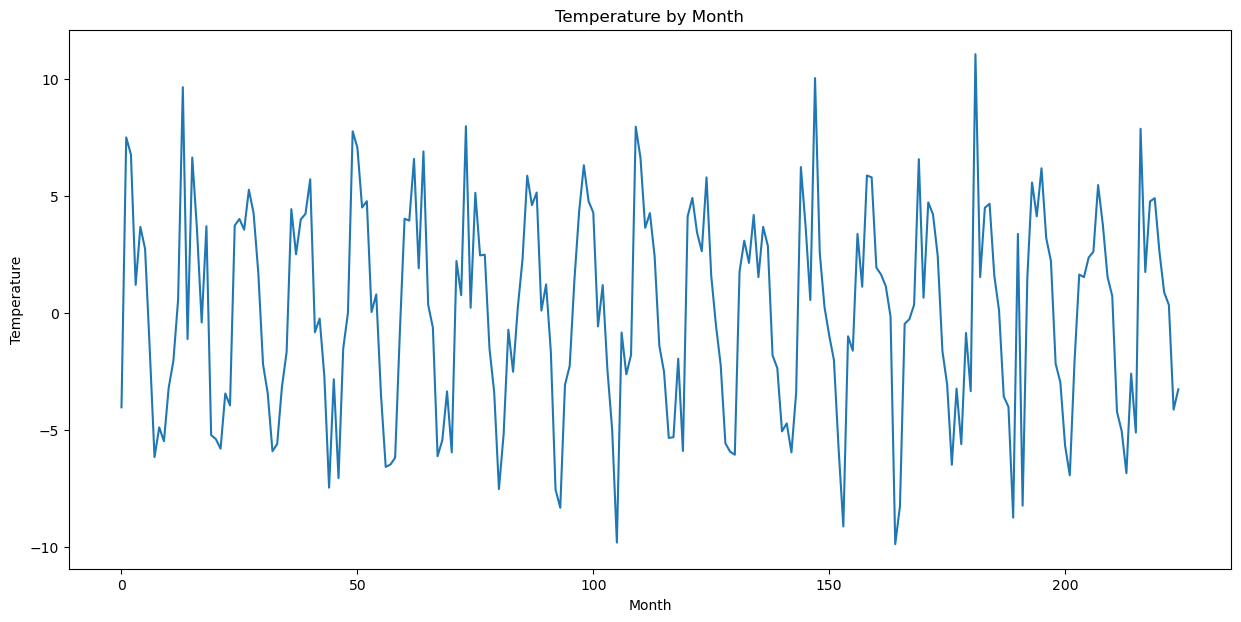

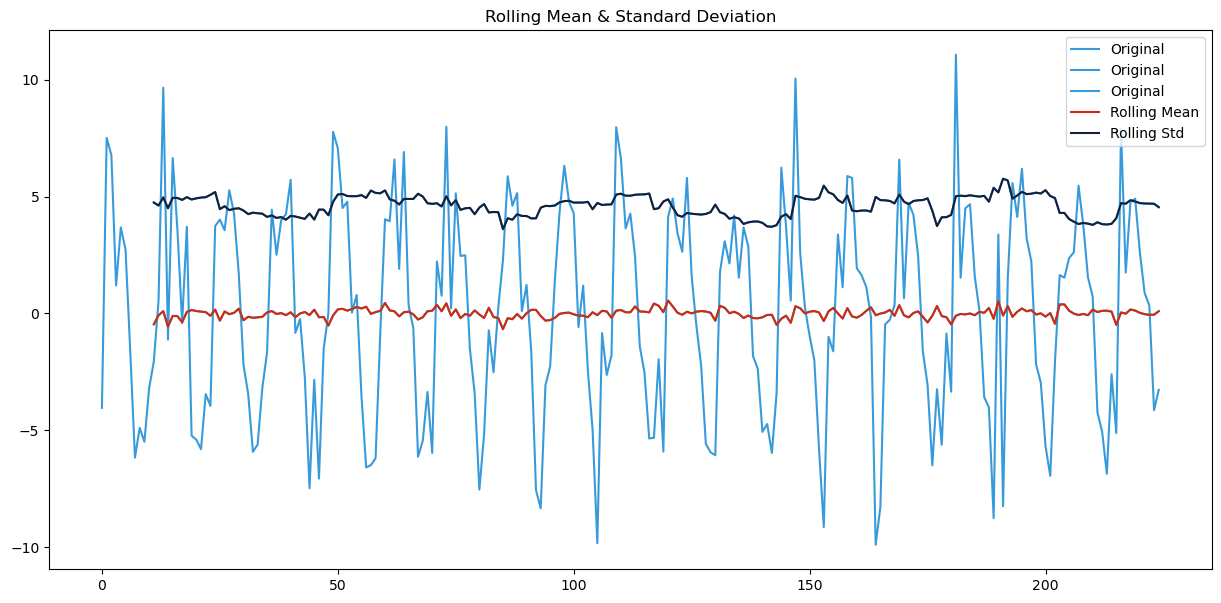

        0  rolling_avg  rolling_std
0   -4.04          NaN          NaN
1    7.51          NaN          NaN
2    6.78          NaN          NaN
3    1.20          NaN          NaN
4    3.68          NaN          NaN
..    ...          ...          ...
220  2.61     0.025833     4.721734
221  0.88    -0.029167     4.706312
222  0.34    -0.060833     4.702089
223 -4.14    -0.053333     4.694901
224 -3.27     0.095833     4.547490

[225 rows x 3 columns]
Results of Dickey Fuller Test for temperature:
Test Statistic                -1.353116e+01
p-value                        2.620039e-25
#Lags Used                     1.000000e+01
Number of Observations Used    2.140000e+02
Critical Value (1%)           -3.461282e+00
Critical Value (5%)           -2.875143e+00
Critical Value (10%)          -2.574020e+00
dtype: float64
Results of Dickey Fuller Test for temperature:
Test Statistic                  -2.284538
p-value                          0.177003
#Lags Used                      11.000000
N

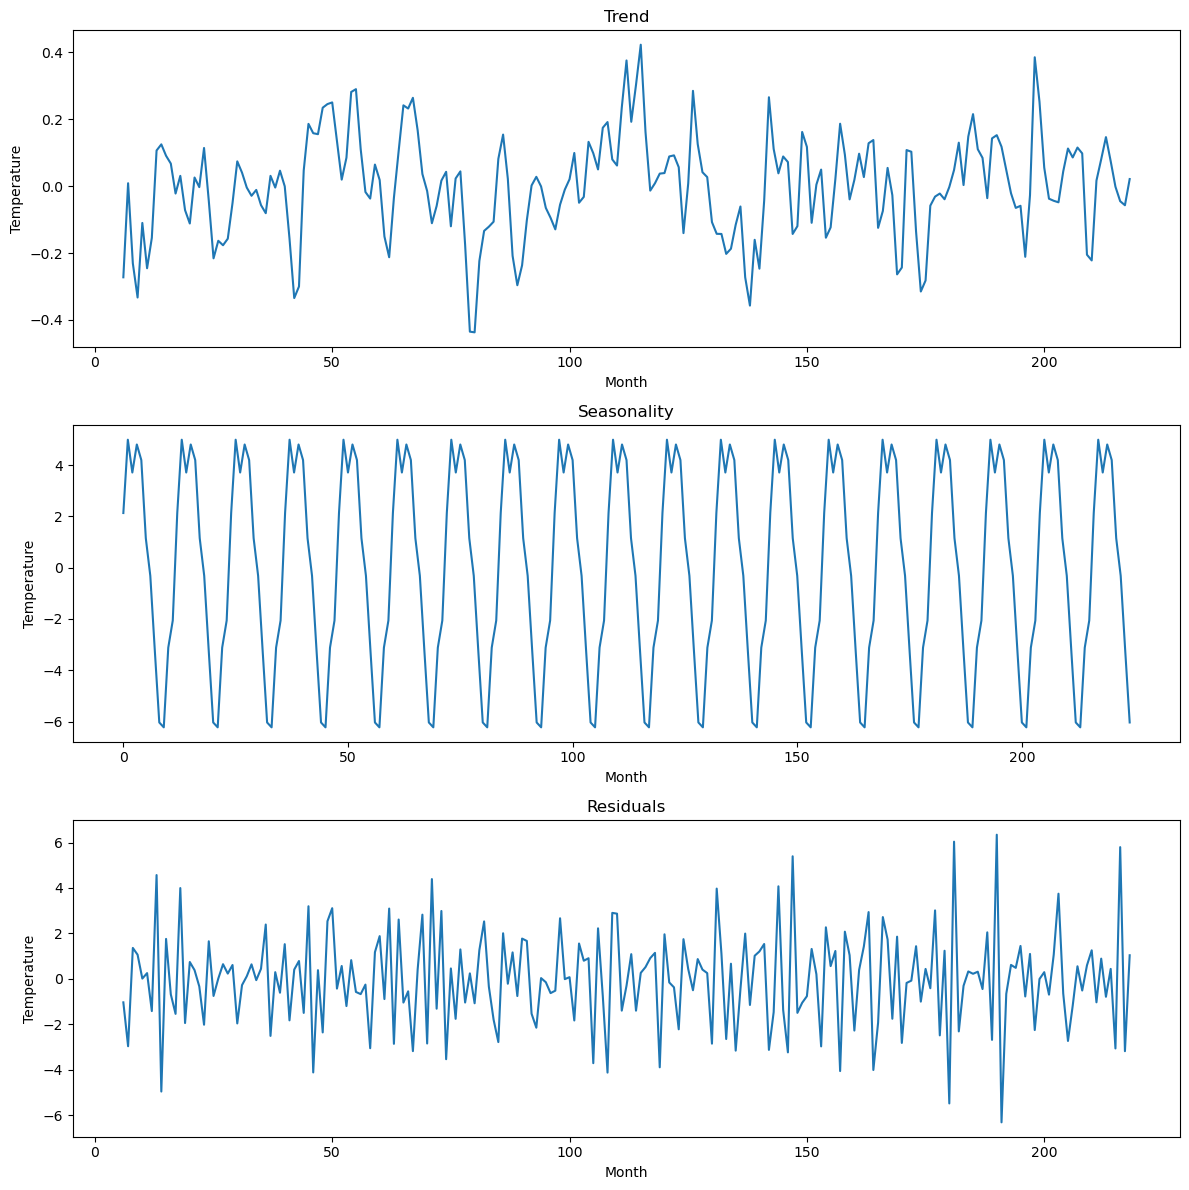

2
Fold 3:
(225, 1)


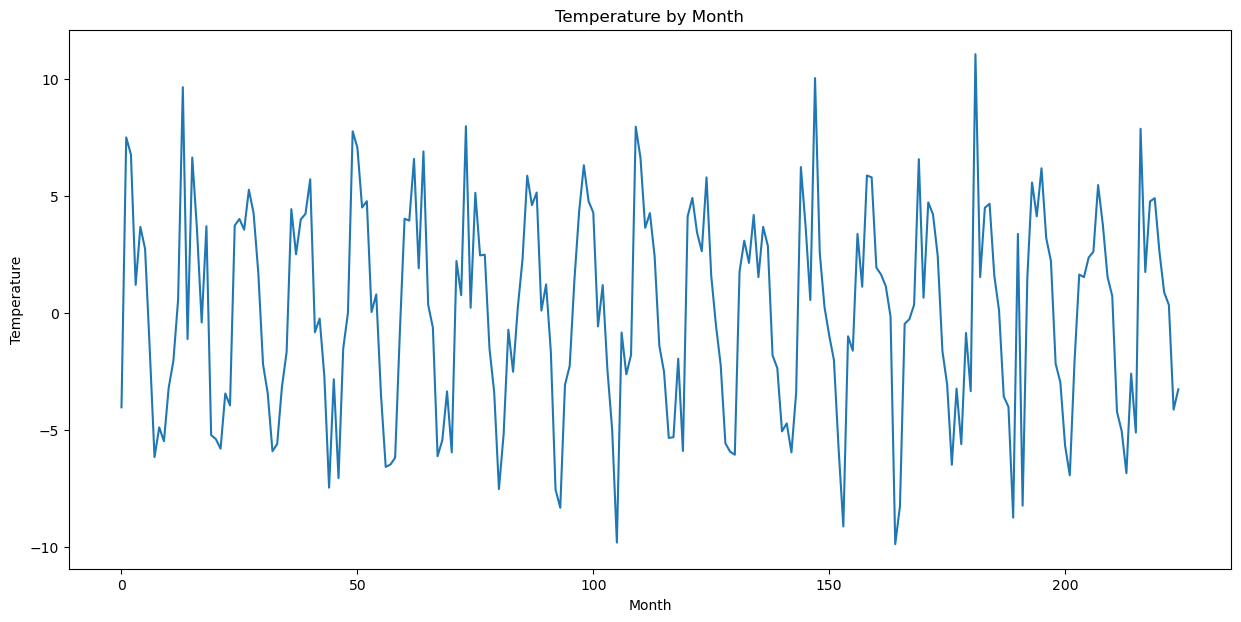

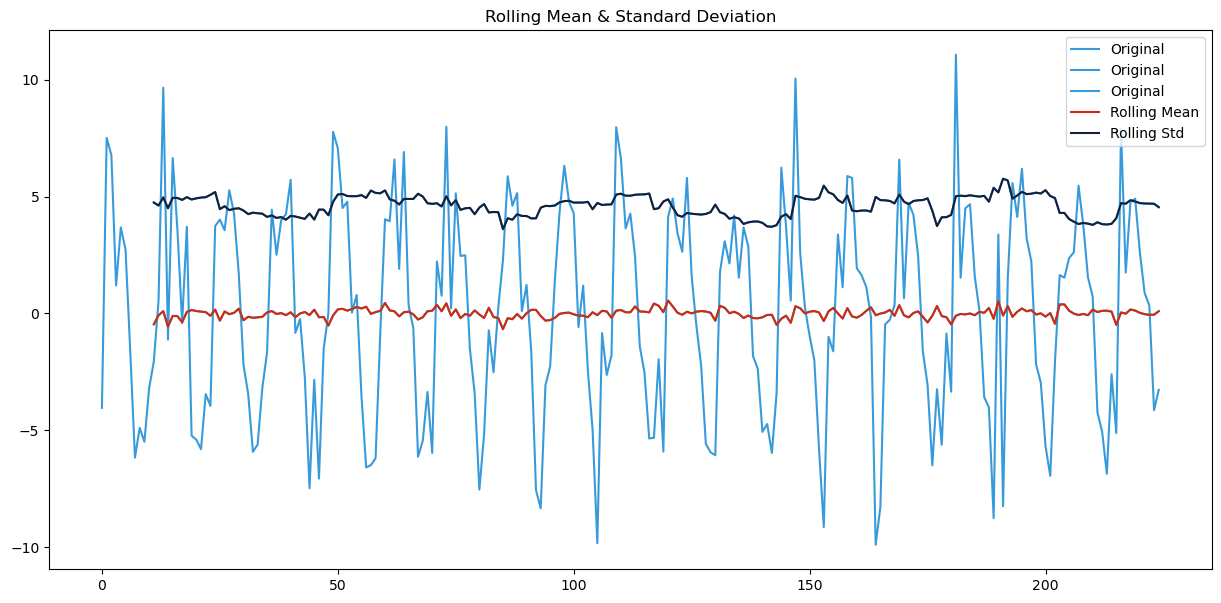

        0  rolling_avg  rolling_std
0   -4.04          NaN          NaN
1    7.51          NaN          NaN
2    6.78          NaN          NaN
3    1.20          NaN          NaN
4    3.68          NaN          NaN
..    ...          ...          ...
220  2.61     0.025833     4.721734
221  0.88    -0.029167     4.706312
222  0.34    -0.060833     4.702089
223 -4.14    -0.053333     4.694901
224 -3.27     0.095833     4.547490

[225 rows x 3 columns]
Results of Dickey Fuller Test for temperature:
Test Statistic                -1.353116e+01
p-value                        2.620039e-25
#Lags Used                     1.000000e+01
Number of Observations Used    2.140000e+02
Critical Value (1%)           -3.461282e+00
Critical Value (5%)           -2.875143e+00
Critical Value (10%)          -2.574020e+00
dtype: float64
Results of Dickey Fuller Test for temperature:
Test Statistic                  -2.284538
p-value                          0.177003
#Lags Used                      11.000000
N

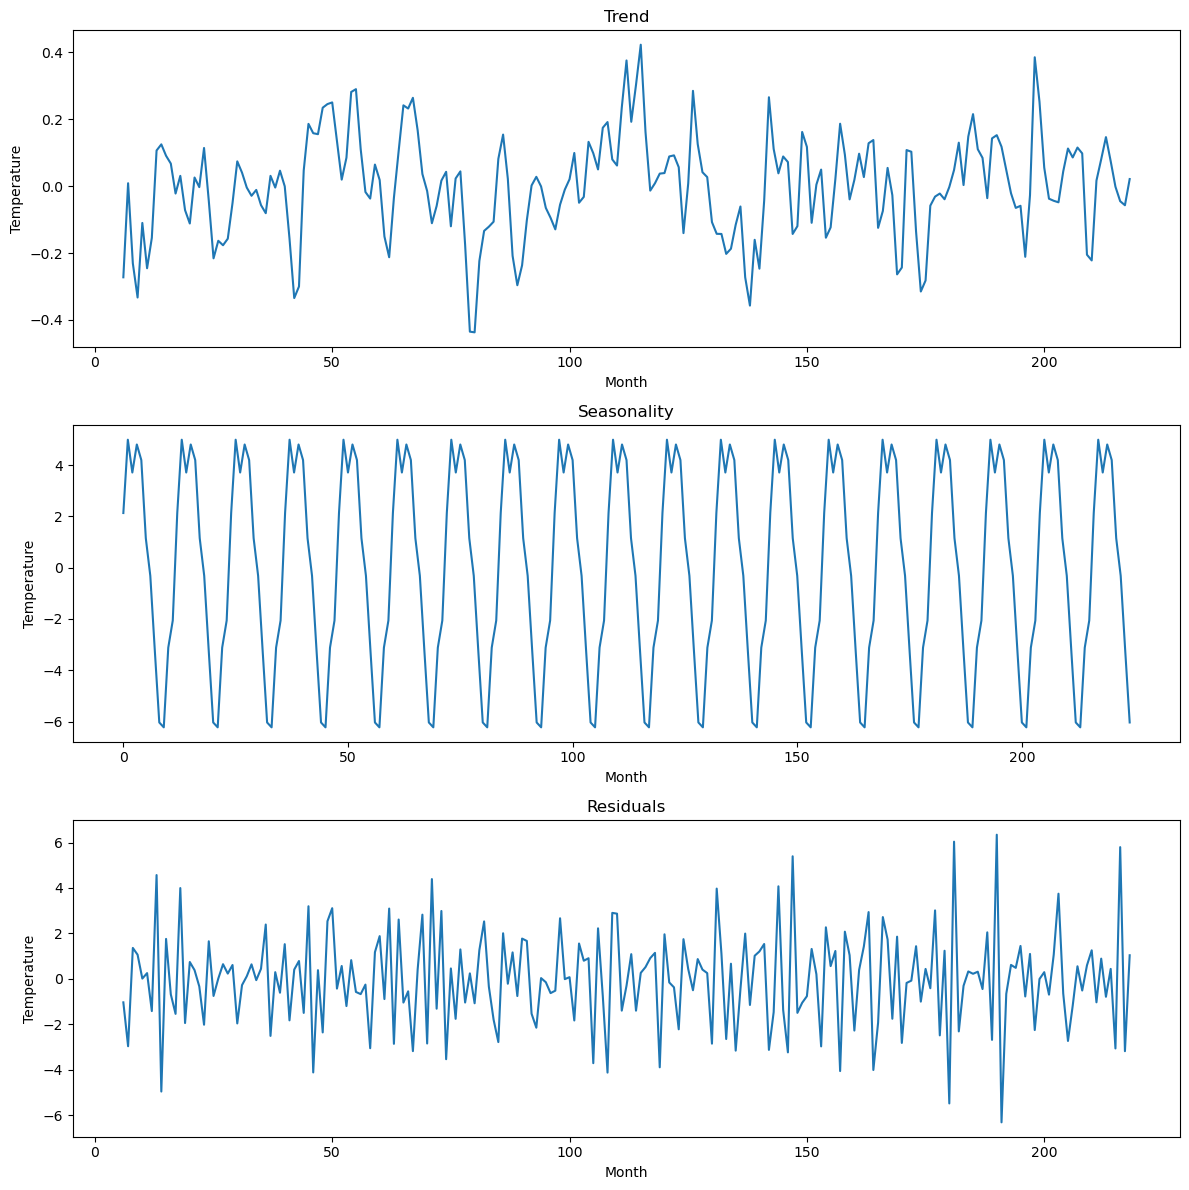

3
Fold 4:
(225, 1)


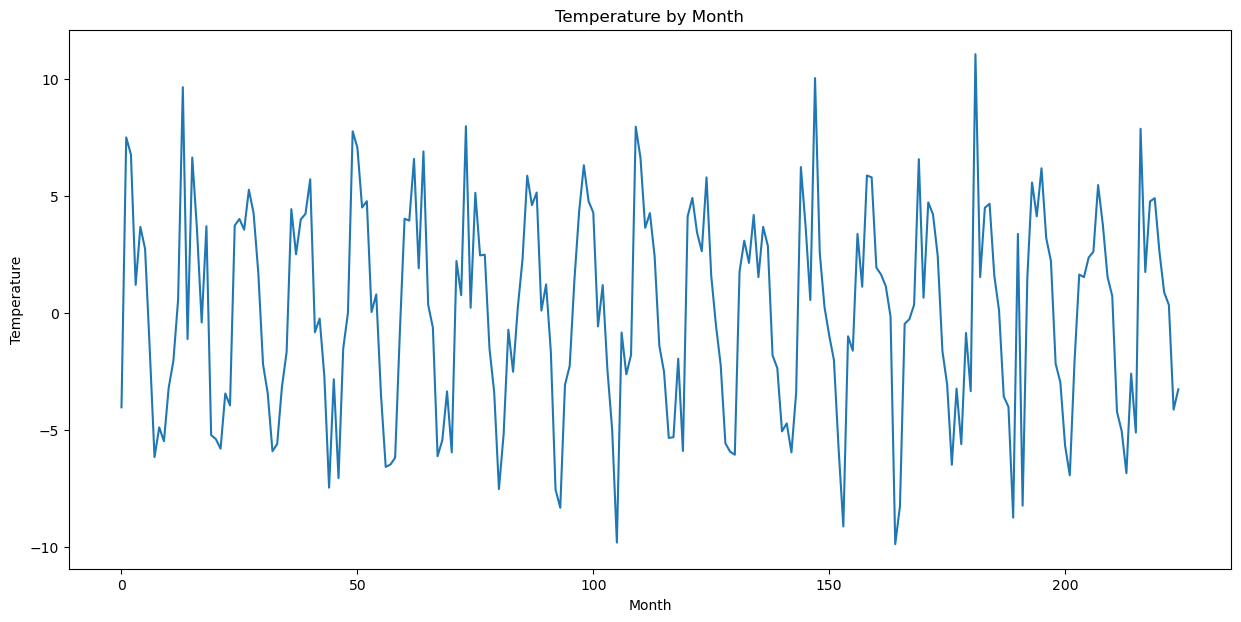

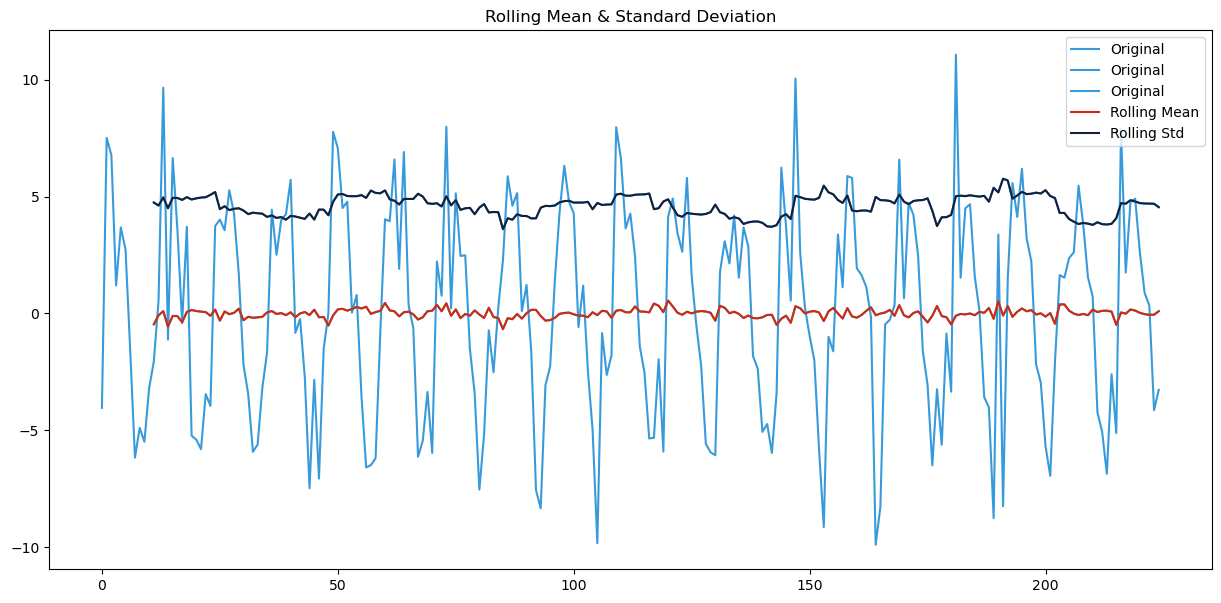

        0  rolling_avg  rolling_std
0   -4.04          NaN          NaN
1    7.51          NaN          NaN
2    6.78          NaN          NaN
3    1.20          NaN          NaN
4    3.68          NaN          NaN
..    ...          ...          ...
220  2.61     0.025833     4.721734
221  0.88    -0.029167     4.706312
222  0.34    -0.060833     4.702089
223 -4.14    -0.053333     4.694901
224 -3.27     0.095833     4.547490

[225 rows x 3 columns]
Results of Dickey Fuller Test for temperature:
Test Statistic                -1.353116e+01
p-value                        2.620039e-25
#Lags Used                     1.000000e+01
Number of Observations Used    2.140000e+02
Critical Value (1%)           -3.461282e+00
Critical Value (5%)           -2.875143e+00
Critical Value (10%)          -2.574020e+00
dtype: float64
Results of Dickey Fuller Test for temperature:
Test Statistic                  -2.284538
p-value                          0.177003
#Lags Used                      11.000000
N

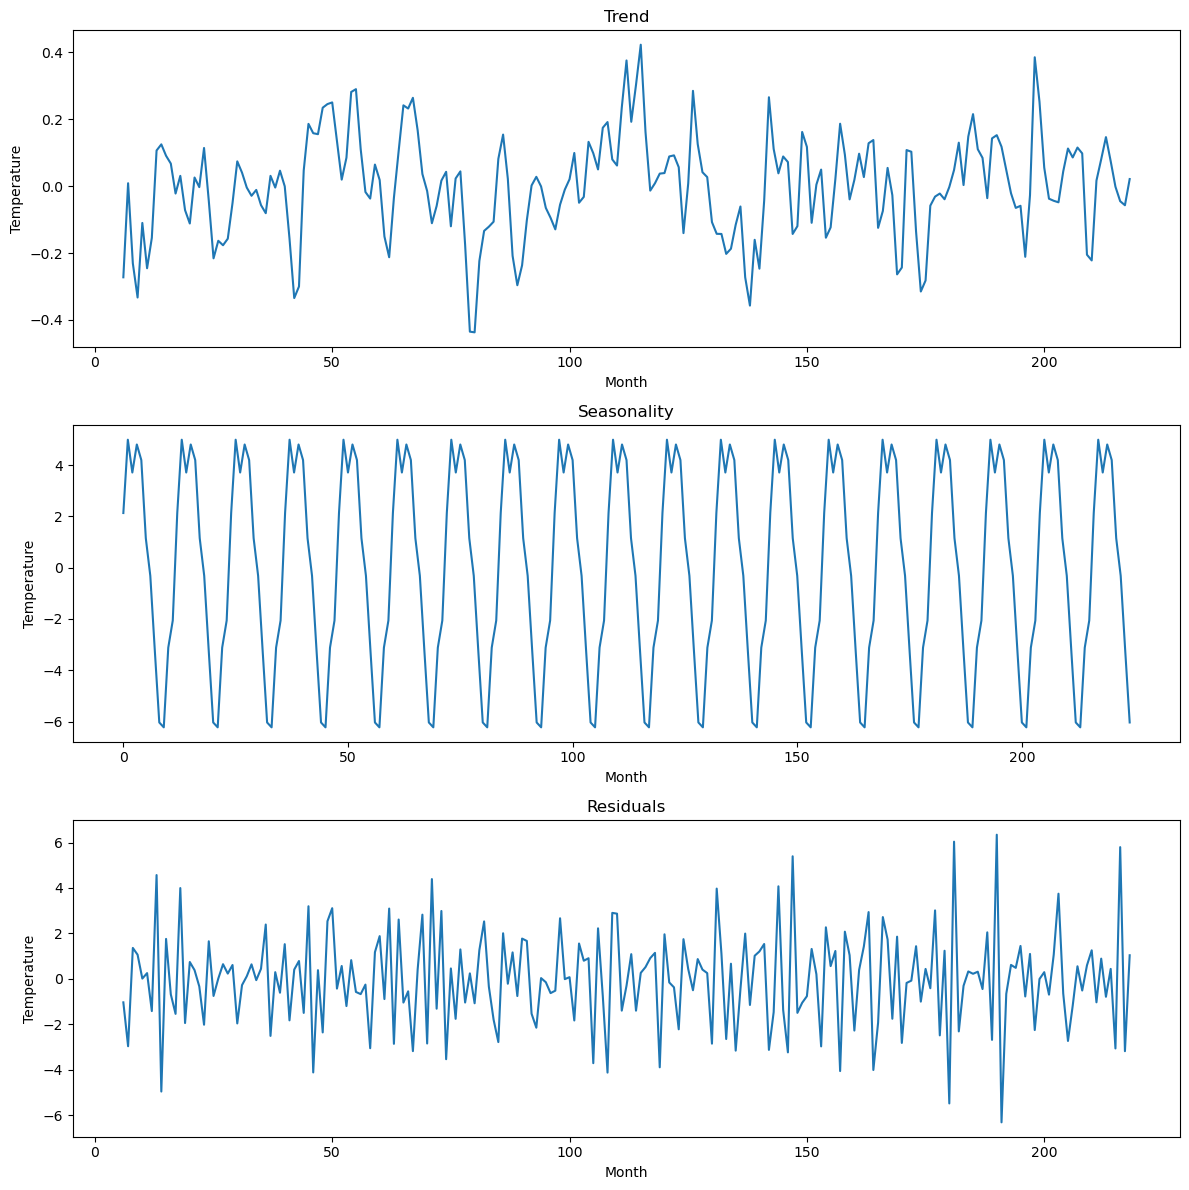

4
Fold 5:
(225, 1)


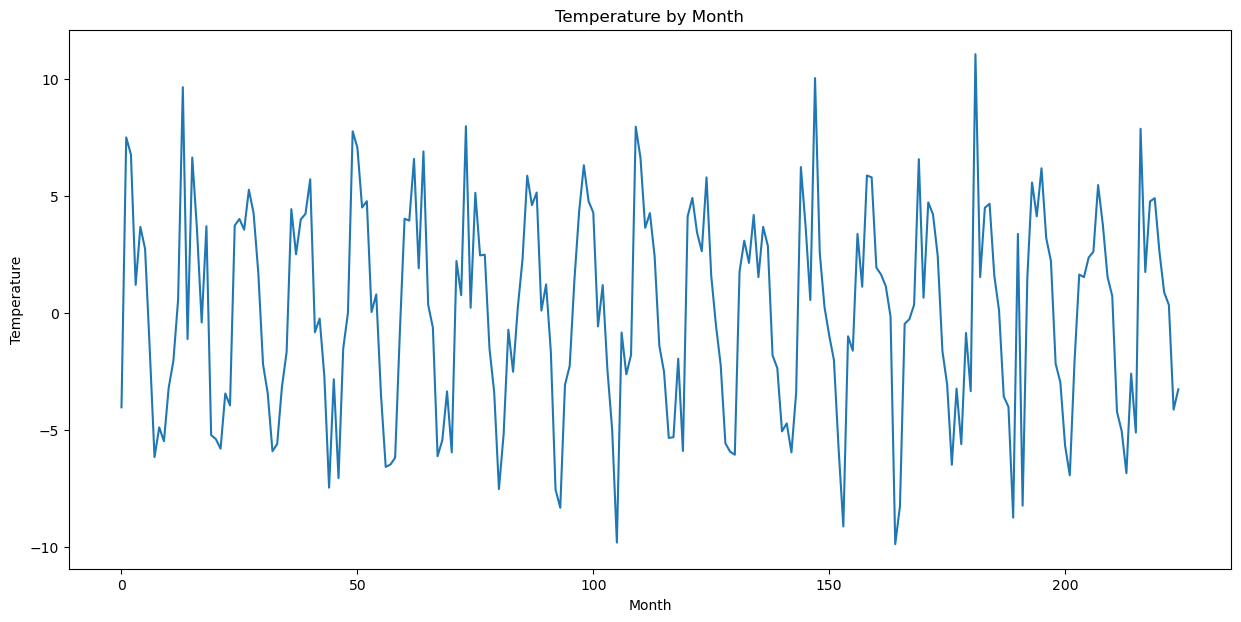

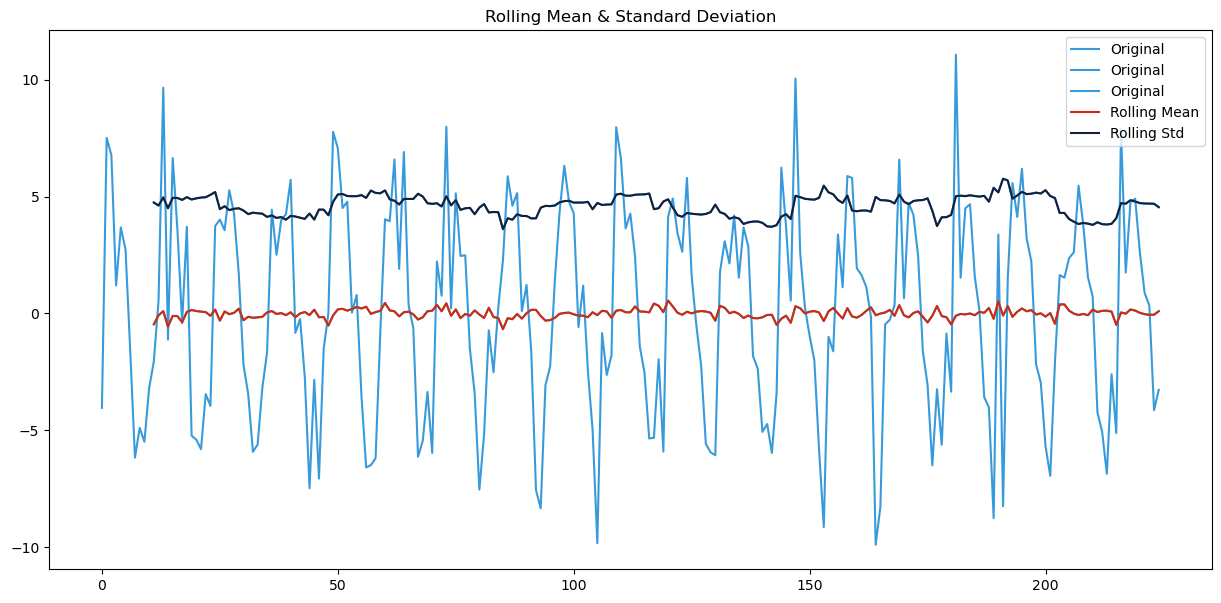

        0  rolling_avg  rolling_std
0   -4.04          NaN          NaN
1    7.51          NaN          NaN
2    6.78          NaN          NaN
3    1.20          NaN          NaN
4    3.68          NaN          NaN
..    ...          ...          ...
220  2.61     0.025833     4.721734
221  0.88    -0.029167     4.706312
222  0.34    -0.060833     4.702089
223 -4.14    -0.053333     4.694901
224 -3.27     0.095833     4.547490

[225 rows x 3 columns]
Results of Dickey Fuller Test for temperature:
Test Statistic                -1.353116e+01
p-value                        2.620039e-25
#Lags Used                     1.000000e+01
Number of Observations Used    2.140000e+02
Critical Value (1%)           -3.461282e+00
Critical Value (5%)           -2.875143e+00
Critical Value (10%)          -2.574020e+00
dtype: float64
Results of Dickey Fuller Test for temperature:
Test Statistic                  -2.284538
p-value                          0.177003
#Lags Used                      11.000000
N

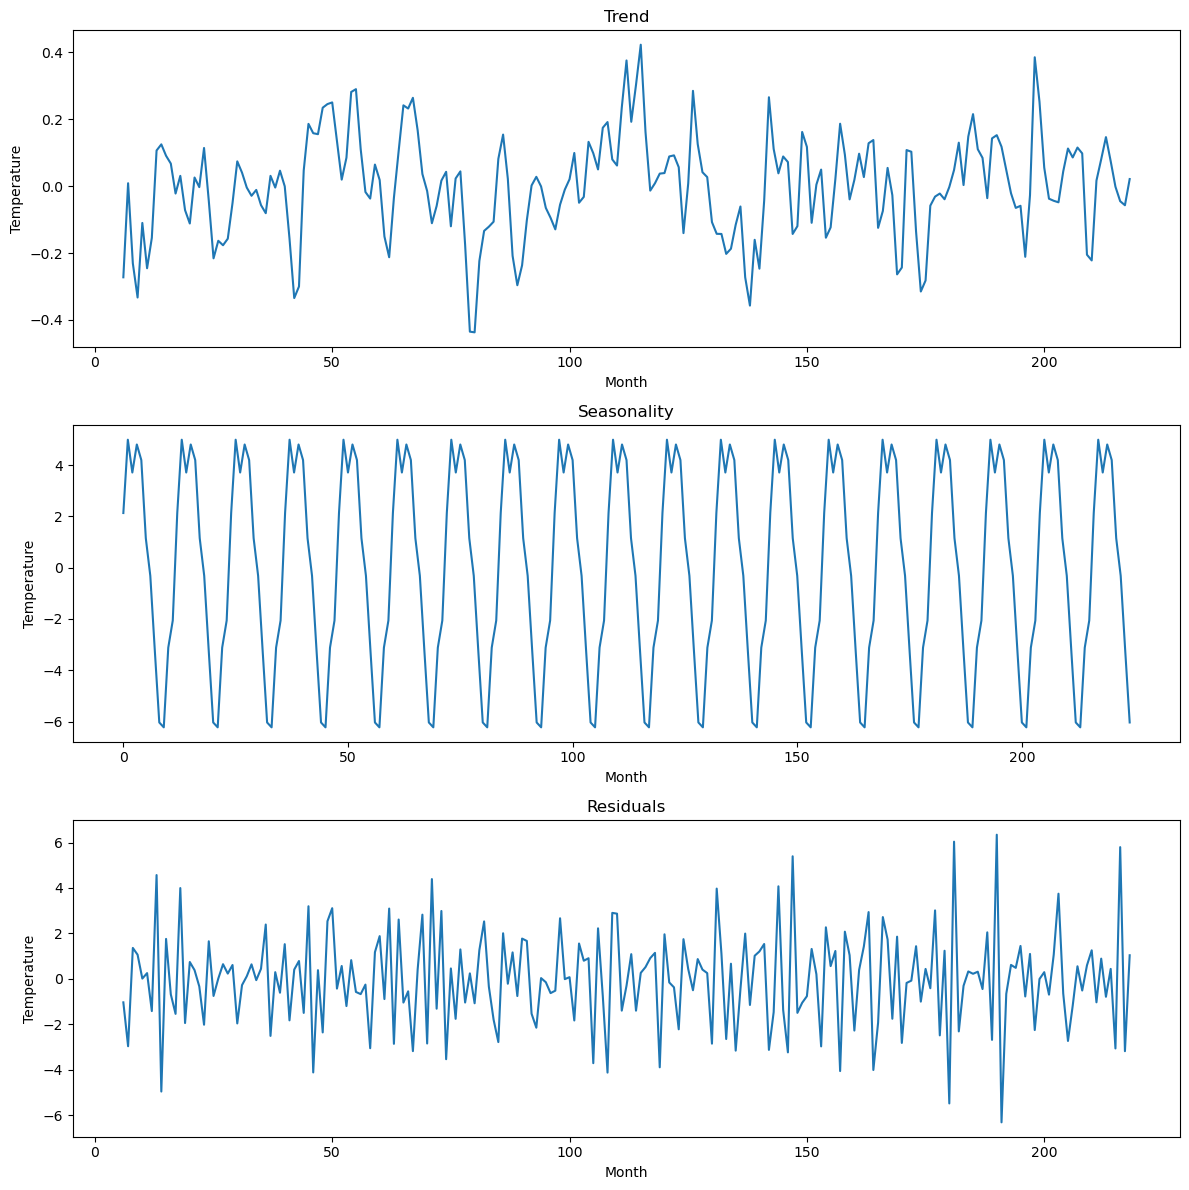

5
ARIMA Temperature Predictions:


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

TypeError: ARIMA.fit() missing 1 required positional argument: 'y'

In [93]:
n_batch=1
X = []
y = []
temp = []
sh = []
PC1 = []
PC2 = []
PC3 = []
X_test = []
y_test = []
temp_test = []
sh_test = []
PC1_test = []
PC2_test = []
PC3_test = []
X_val = []
y_val = []
temp_val = []
sh_val = []
PC1_val = []
PC2_val = []
PC3_val = []

for i in range(5):
    print("Fold "+str(i+1)+":")

    # Prepare data for statistics
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    
    # Grab data for first weather station file_id=6501
    X1 = pd.DataFrame(train1[0])
    y1 = X1[X1.columns[0]]
    y_df = pd.DataFrame(test1[:][0])
    y_df['Temperature'] = y_df[y_df.columns[0]]
    y_df = y_df.drop(y_df.columns[:5], axis=1)
    y_df = scaler[i].inverse_transform(y_df)
    y_df = pd.DataFrame(y_df)
    print(y_df.shape)

    #Plot data
    plot_data(y_df, "Temperature")

    #Get rolling statistics
    rolling_statistics(y_df)
    print(y_df)

    # Run Dickey-Fuller test to check if stationary
    y1 = y_df[y_df.columns[0]]
    y_original = results_df[results_df['file_id']==6501]['temperatures']
    ADF(y1)
    ADF(y_original)

    # Decomposing the time series with an appropriate period based on the data's seasonality
    decomposition_filled = seasonal_decompose(y1, model='additive', period=12) # Monthly seasonality

    # Plotting the decomposed components of the time series
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
    decomposition_filled.trend.plot(ax=ax1)
    ax1.set_title('Trend')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Temperature')

    decomposition_filled.seasonal.plot(ax=ax2)
    ax2.set_title('Seasonality')
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Temperature')

    decomposition_filled.resid.plot(ax=ax3)
    ax3.set_title('Residuals')
    ax3.set_xlabel('Month')
    ax3.set_ylabel('Temperature')

    plt.tight_layout()
    plt.show()

    # Transform data for ARIMA and SARIMAX

    # Transform training data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(train1, n_lag, n_seq)
    X.append(X_row)
    temp.append(temp_row)
    sh.append(sh_row)
    PC1.append(PC1_row)
    PC2.append(PC2_row)
    PC3.append(PC3_row)
    y.append(y_row)
    
    print(len(y))

    # Transform testing data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(test1, n_lag, n_seq)
    X_test.append(X_row)
    temp_test.append(temp_row)
    sh_test.append(sh_row)
    PC1_test.append(PC1_row)
    PC2_test.append(PC2_row)
    PC3_test.append(PC3_row)
    y_test.append(y_row)


    # Transform validation data
    X_row, y_row, temp_row, sh_row, PC1_row, PC2_row, PC3_row = transform_data(validation1, n_lag, n_seq)
    X_val.append(X_row)
    temp_val.append(temp_row)
    sh_val.append(sh_row)
    PC1_val.append(PC1_row)
    PC2_val.append(PC2_row)
    PC3_val.append(PC3_row)
    y_val.append(y_row)

# Run models
    
# Predict temperature

# ARIMA model (for ARIMA model, all the SARIMAX model seasonal parameters are zero)

print("ARIMA Temperature Predictions:")


ARIMA_model = fit_ARIMA_model(y, y_val, n_seq)
plot_diagnostics(ARIMA_model)

# SARIMAX model

# Create exogenous variables dataframe
for i in range(n_vars-1):
    data['temp_col'] = exog[i]
    colname = 'exog' + str(i+1)
    data.rename(columns={'temp_col': colname}, inplace=True)
    
print("SARIMAX Temperature Dataframe:")
print(data)
        
SARIMAX_model = fit_SARIMAX_model(y, y_val, exog, n_seq)
plot_diagnostics(SARIMAX_model)

In [ ]:
def add_padding(y):

    # Create rows of padding with zeros
    if isinstance(y[0][0], float) or isinstance(y[0][0], int):
        n_vars = 1
    else:
        n_vars = len(y[0][0])

    if n_vars == 1:
        padding = 0 * n_vars
    else:
        padding = [0 * n_vars]

    data = []
    
    for p in range(len(y)):
        for q in range(len(y[0])):
            data.append(y[p][q])
        
        for r in range(12):
            data.append(padding)

    return data

In [57]:
print(pd.DataFrame(y_test[0][0]).shape)

(179, 1)


In [ ]:
results_full_df = results_df #grab full dataset before removing last 4 years

results_df = results_df[pd.to_datetime(results_df['date']) < datetime.strptime("2021-1-1", "%Y-%m-%d")]

# Get test dataframe
results_test_df = results_full_df
results_test_df = results_test_df[pd.to_datetime(results_test_df['date']) > datetime.strptime("2020-12-31", "%Y-%m-%d")]
results_test_df = results_test_df.reset_index()

print(results_df)

# Get test values for specific humidity and temperature
specific_humidity_test_values = results_test_df['specific_humidity']
temperature_test_values = results_test_df['temperatures']

print(specific_humidity_test_values)
print(temperature_test_values)

# define a series for each column in the data frame that needs to be normalized
# Normalized columns: temperatures, specific_humidity, slp, water, region, wet_bulb_temperature,
# GHI, SNDP, latitude, longitude, elevation, Year, Month, Day, solar_activity, ONI

data = []
scaler = []
scaled_data = []

# Get Data
data.append(results_df['temperatures'])
data.append(results_df['specific_humidity'])
data.append(results_df['PC1'])
data.append(results_df['PC2'])
data.append(results_df['PC3'])

#data.append(results_df['slp'])
#data.append(results_df['water'])
#data.append(results_df['region'])
#data.append(results_df['wet_bulb_temperature'])
#data.append(results_df['GHI'])
#data.append(results_df['SNDP'])
#data.append(results_df['solar_activity'])
#data.append(results_df['ONI'])
#data.append(results_df['latitude'])
#data.append(results_df['longitude'])
#data.append(results_df['elevation'])
#data.append(results_df['Year'])
#data.append(results_df['Month'])
#data.append(results_df['Day'])

n_vars = 5 # Number of variables/predictors

# Data Preparation: Scale Data
for i in range(n_vars):
    scaler.append(StandardScaler())
    scaled_data.append([0])    
    
scaler, scaler_all_features, scaled_data = prepare_data(data)

dates = pd.date_range(start='2006-01-01', periods=180, freq='ME')

In [ ]:
# ARIMA model (for ARIMA model, all the SARIMAX model seasonal parameters are zero)

# Predict temperature

print("ARIMA Temperature Predictions:")

y = scaled_data[0] # y = temperature

for i in range(n_vars-1):
    j=i+1
    exog.append(scaled_data[j])

# Reconstruct the data frame with standardized values
data = pd.DataFrame({'y': y}, index=dates)

for i in range(n_vars-1):
    data['temp_col'] = exog[i]
    colname = 'exog' + str(i+1)
    data.rename(columns={'temp_col': colname}, inplace=True)

print("ARIMA Temperature Dataframe:")
print(data)

# Fit the ARIMA model
model_temp_ARMA = SARIMAX(data['y'], exog=None, order=(1, 0, 1), seasonal_order=(0, 0, 0, 0))
results_temp_ARMA = model_temp_ARMA.fit(disp=False)

# Print the summary of the model
print(results_temp_ARMA.summary())

# Forecasting
n_forecast = 47
forecast_temp_ARMA = results_temp_ARMA.get_forecast(steps=n_forecast, exog=exog[-n_forecast:])
forecast_temp_ARMA_mean = forecast_temp_ARMA.predicted_mean
forecast_temp_ARMA_ci = forecast_temp_ARMA.conf_int()

# Print the forecasted values
print(forecast_temp_ARMA_mean)
print(forecast_temp_ARMA_ci)

# Reshape data
forecast_temp_ARMA_mean = np.array(forecast_temp_ARMA_mean)
forecast_temp_ARMA_mean = forecast_temp_ARMA_mean.reshape(-1,1)

# Inverse transform and print forecast
inversed_temp_ARMA_mean = scaler1.inverse_transform(forecast_temp_ARMA_mean)
inversed_temp_ARMA_ci = scaler1.inverse_transform(forecast_temp_ARMA_ci)
print(inversed_temp_ARMA_mean)
print(inversed_temp_ARMA_ci)
print(temperature_test_values)

dates_predicted = pd.date_range(start='2021-01-01', periods=47, freq='ME')

combined_temp_ARMA = []
for i in range(len(temperature_test_values)):
    combined_temp_ARMA.append([dates_predicted[i], inversed_temp_ARMA_mean[i, 0], temperature_test_values[i]])

combined_temp_ARMA = pd.DataFrame(combined_temp_ARMA)
combined_temp_ARMA.columns = ['prediction_date', 'predicted_temp', 'actual_temp']

combined_temp_ARMA['error_pct'] = 100 * (combined_temp_ARMA['actual_temp'] - combined_temp_ARMA['predicted_temp'])/combined_temp_ARMA['actual_temp']

# Set display option to show all rows
pd.set_option('display.max_rows', 47)

print(combined_temp_ARMA.head(47))


In [ ]:
# SARIMAX model

print("SARIMAX Temperature Predictions:")

# Fit the SARIMAX model
model_temp_SARIMAX = SARIMAX(data['y'], exog=exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results_temp_SARIMAX = model_temp_SARIMAX.fit(disp=False)

# Print the summary of the model
print(results_temp_SARIMAX.summary())

# Forecasting
n_forecast = 47
forecast_temp_SARIMAX = results_temp_SARIMAX.get_forecast(steps=n_forecast, exog=exog[-n_forecast:])
forecast_temp_SARIMAX_mean = forecast_temp_SARIMAX.predicted_mean
forecast_temp_SARIMAX_ci = forecast_temp_SARIMAX.conf_int()

# Print the forecasted values
print(forecast_temp_SARIMAX_mean)
print(forecast_temp_SARIMAX_ci)

# Reshape data
forecast_temp_SARIMAX_mean = np.array(forecast_temp_SARIMAX_mean)
forecast_temp_SARIMAX_mean = forecast_temp_SARIMAX_mean.reshape(-1,1)

# Inverse transform and print forecast
inversed_temp_SARIMAX_mean = scaler1.inverse_transform(forecast_temp_SARIMAX_mean)
inversed_temp_SARIMAX_ci = scaler1.inverse_transform(forecast_temp_SARIMAX_ci)
print(inversed_temp_SARIMAX_mean)
print(inversed_temp_SARIMAX_ci)
print(temperature_test_values)

dates_predicted = pd.date_range(start='2021-01-01', periods=47, freq='ME')

combined_temp_SARIMAX = []
for i in range(len(temperature_test_values)):
    combined_temp_SARIMAX.append([dates_predicted[i], inversed_temp_SARIMAX_mean[i, 0], temperature_test_values[i]])

combined_temp_SARIMAX = pd.DataFrame(combined_temp_SARIMAX)
combined_temp_SARIMAX.columns = ['prediction_date', 'predicted_temp', 'actual_temp']

combined_temp_SARIMAX['error_pct'] = 100 * (combined_temp_SARIMAX['actual_temp'] - combined_temp_SARIMAX['predicted_temp'])/combined_temp_SARIMAX['actual_temp']

# Set display option to show all rows
pd.set_option('display.max_rows', 47)

print(combined_temp_SARIMAX.head(47))

In [ ]:
# Predict specific humidity

# ARIMA model

print("ARIMA Specific Humidity Predictions:")

# Swap temperature and specific humidity in the dataframe
data['y'] = pd.DataFrame(scaled_data[1]) # y = specific humidity
data['exog1'] = pd.DataFrame(scaled_data[0]) # exog1 = temperature

# Define the exogenous variables
exog = (data.drop(['y'])).values

print(exog)

# Fit the SARIMAX model
model_sh_ARMA = SARIMAX(data['y'], exog=None, order=(1, 0, 1), seasonal_order=(0, 0, 0, 0))
results_sh_ARMA = model_sh_ARMA.fit(disp=False)

# Print the summary of the model
print(results_sh_ARMA.summary())

# Forecasting
n_forecast = 47
forecast_sh_ARMA = results_sh_ARMA.get_forecast(steps=n_forecast, exog=exog[-n_forecast:])
forecast_sh_ARMA_mean = forecast_sh_ARMA.predicted_mean
forecast_sh_ARMA_ci = forecast_sh_ARMA.conf_int()

# Print the forecasted values
print(forecast_sh_ARMA_mean)
print(forecast_sh_ARMA_ci)

# Reshape data
forecast_sh_ARMA_mean = np.array(forecast_sh_ARMA_mean)
forecast_sh_ARMA_mean = forecast_sh_ARMA_mean.reshape(-1,1)

# Inverse transform and print forecast
inversed_sh_ARMA_mean = scaler1.inverse_transform(forecast_sh_ARMA_mean)
inversed_sh_ARMA_ci = scaler1.inverse_transform(forecast_sh_ARMA_ci)
print(inversed_sh_ARMA_mean)
print(inversed_sh_ARMA_ci)
print(specific_humidity_test_values)

dates_predicted = pd.date_range(start='2021-01-01', periods=47, freq='ME')

combined_sh_ARMA = []
for i in range(len(specific_humidity_test_values)):
    combined_sh_ARMA.append([dates_predicted[i], inversed_sh_ARMA_mean[i, 0], specific_humidity_test_values[i]])

combined_sh_ARMA = pd.DataFrame(combined_sh_ARMA)
combined_sh_ARMA.columns = ['prediction_date', 'predicted_sh', 'actual_sh']

combined_sh_ARMA['error_pct'] = 100 * (combined_sh_ARMA['actual_sh'] - combined_sh_ARMA['predicted_sh'])/combined_sh_ARMA['actual_sh']

# Set display option to show all rows
pd.set_option('display.max_rows', 47)

print(combined_sh_ARMA.head(47))

In [ ]:
# SARIMAX model

print("SARIMAX Specific Humidity Predictions:")

# Fit the SARIMAX model
model_sh_SARIMAX = SARIMAX(data['y'], exog=exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results_sh_SARIMAX = model_sh_SARIMAX.fit(disp=False)

# Print the summary of the model
print(results_sh_SARIMAX.summary())

# Forecasting
n_forecast = 47
forecast_sh_SARIMAX = results_sh_SARIMAX.get_forecast(steps=n_forecast, exog=exog[-n_forecast:])
forecast_sh_SARIMAX_mean = forecast_sh_SARIMAX.predicted_mean
forecast_sh_SARIMAX_ci = forecast_sh_SARIMAX.conf_int()

# Print the forecasted values
print(forecast_sh_SARIMAX_mean)
print(forecast_sh_SARIMAX_ci)

# Reshape data
forecast_sh_SARIMAX_mean = np.array(forecast_sh_SARIMAX_mean)
forecast_sh_SARIMAX_mean = forecast_sh_SARIMAX_mean.reshape(-1,1)

# Inverse transform and print forecast
inversed_sh_SARIMAX_mean = scaler1.inverse_transform(forecast_sh_SARIMAX_mean)
inversed_sh_SARIMAX_ci = scaler1.inverse_transform(forecast_sh_SARIMAX_ci)
print(inversed_sh_SARIMAX_mean)
print(inversed_sh_SARIMAX_ci)
print(specific_humidity_test_values)

dates_predicted = pd.date_range(start='2021-01-01', periods=47, freq='ME')

combined_sh_SARIMAX = []
for i in range(len(specific_humidity_test_values)):
    combined_sh_SARIMAX.append([dates_predicted[i], inversed_sh_SARIMAX_mean[i, 0], specific_humidity_test_values[i]])

combined_sh_SARIMAX = pd.DataFrame(combined_sh_SARIMAX)
combined_sh_SARIMAX.columns = ['prediction_date', 'predicted_sh', 'actual_sh']

combined_sh_SARIMAX['error_pct'] = 100 * (combined_sh_SARIMAX['actual_sh'] - combined_sh_SARIMAX['predicted_sh'])/combined_sh_SARIMAX['actual_sh']

# Set display option to show all rows
pd.set_option('display.max_rows', 47)

print(combined_sh_SARIMAX.head(47))